In [1]:
import non_dim_lderiv_control as ld
# import energy_reward as ld
import copy
import gym
import numpy as np
import pandas as pd
import scipy.integrate as si
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from stable_baselines3 import A2C, PPO, SAC, TD3, DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import CheckpointCallback

In [2]:
lmin = 0.95
lmax = 1.05
phi_0 = np.pi / 4
phidot_0 = 0
tau = .125
ldot_max = 0.1
power_max = 100
rtol = 0.02

In [3]:
power_bounded = power_max < 1
env = ld.Swing(power_bounded=power_bounded)
env.ldot_max = ldot_max
env.lmin = lmin
env.lmax = lmax
env.ldot_max = ldot_max
env.phi_0 = phi_0
env.phidot_0 = phidot_0
env.tau = tau
env.power_max = power_max
env.rtol = rtol

/Users/iandavenport/opt/anaconda3/lib/python3.7/site-packages/gym/spaces/box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


In [ ]:
checkpoint_callback = CheckpointCallback(
    save_freq=50_000,
    save_path="./time_unbounded_models/",
    name_prefix="rl_model",
)

In [ ]:
# policy_kwargs = dict(net_arch=dict(pi=[256, 256]))
# model = SAC("MlpPolicy", env, verbose=1, tensorboard_log="min_time_logs/") 
# model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="energy_bounded_logs/")
model = PPO.load("energy_unbounded_models/rl_model_400000_steps.zip", env = env, tensorboard_log="time_unbounded_logs/")
model.learn(total_timesteps=5e6, callback=checkpoint_callback)

In [5]:
env = ld.Swing(power_bounded=power_bounded)
env.ldot_max = ldot_max
env.lmin = lmin
env.lmax = lmax
# env.L = [env.lmax]
env.ldot_max = ldot_max
env.phi_0 = phi_0
env.phidot_0 = phidot_0
env.power_max = power_max
env.tau = 0.005 # tau/200
env.pump_limit = 500e3
env.rtol = 0.001
model = PPO.load("time_unbounded_models/rl_model_450000_steps.zip", env=env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [6]:
done = False
obs = env.reset()
env.L = [env.lmax]
while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, _ = env.step(action.item())

phi_hist = np.array(env.phi)
l_hist = np.array(env.L)

x_t = l_hist * np.sin(phi_hist)
y_t = -l_hist * np.cos(phi_hist)
ref_x = np.array(env.lmax) * np.sin(env.phi)
ref_y = -np.array(env.lmax) * np.cos(env.phi)

Text(0.5, 1.0, 'Angle over time')

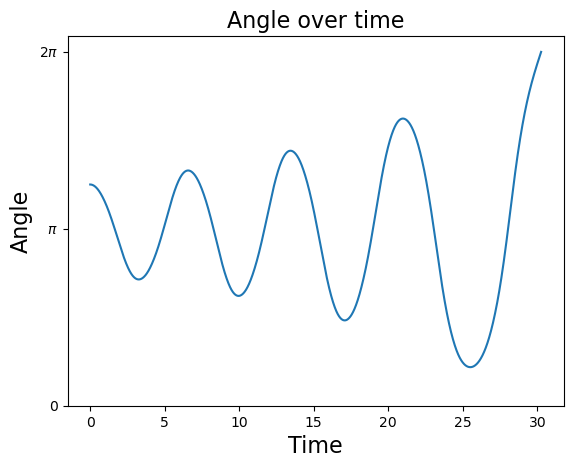

In [7]:
fontdict = {"fontsize": 16}
plt.plot(
    env.tau * np.arange(len(env.phi)), np.mod(np.array(env.phi) + np.pi, 2 * np.pi)
)
plt.yticks([0, np.pi, 2 * np.pi], ["0", r"$\pi$", r"2$\pi$"])
plt.xlabel("Time", fontdict=fontdict)
plt.ylabel("Angle", fontdict=fontdict)
plt.title("Angle over time", fontdict=fontdict)
#plt.savefig("theta.png")

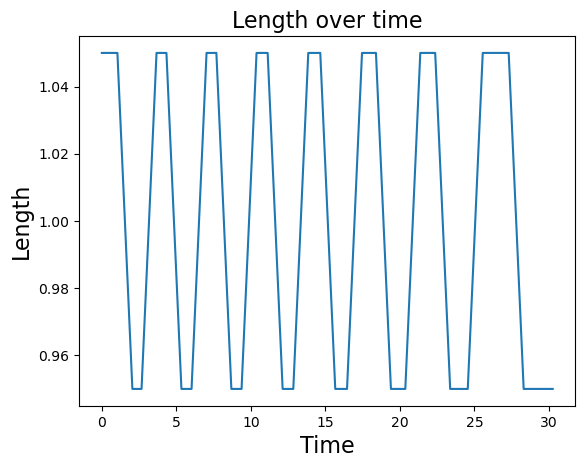

In [8]:
plt.plot(env.tau * np.arange(len(env.phi)), env.L)
plt.xlabel("Time", fontdict=fontdict)
plt.ylabel("Length", fontdict=fontdict)
plt.title("Length over time", fontdict=fontdict)
#plt.savefig("length.png")
plt.show()

Text(0.5, 1.0, 'Lengths and Angles over time')

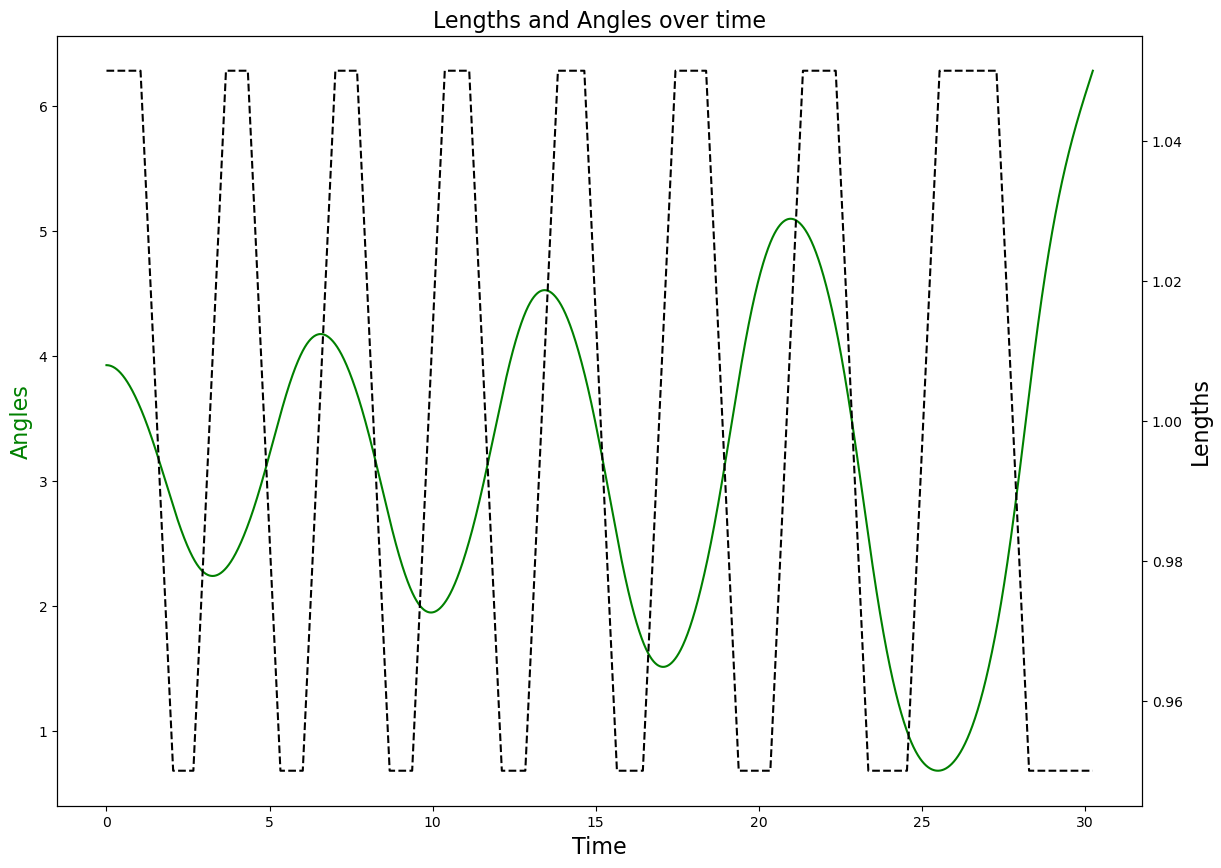

In [9]:
fig, ax1 = plt.subplots(figsize=(14, 10))

ax2 = ax1.twinx()
ax1.plot(
    env.tau* np.arange(len(env.phi)),
    np.mod(np.array(env.phi) + np.pi, 2 * np.pi),
    "g-",
)
ax2.plot(env.tau* np.arange(len(env.phi)), env.L, "k--")

ax1.set_xlabel("Time", fontsize=16)
ax1.set_ylabel("Angles", color="g", fontsize=16)
ax2.set_ylabel("Lengths", color="k", fontsize=16)

plt.title("Lengths and Angles over time", fontsize=16)
#plt.savefig("overlay.png")

In [10]:
t = env.tau * np.arange(len(env.phi))#[:-1]
phi = np.mod(np.array(env.phi) + np.pi, 2 * np.pi)#[:-1]
l_dot_hist_t = env.tau * np.arange(len(env.Ldot_hist))#[:-1]
l_dot_hist = env.Ldot_hist#[:-1]
# smooth_angle = savgol_filter(phi, 9, 2)

Text(0.5, 1.0, 'Control and Angle over time')

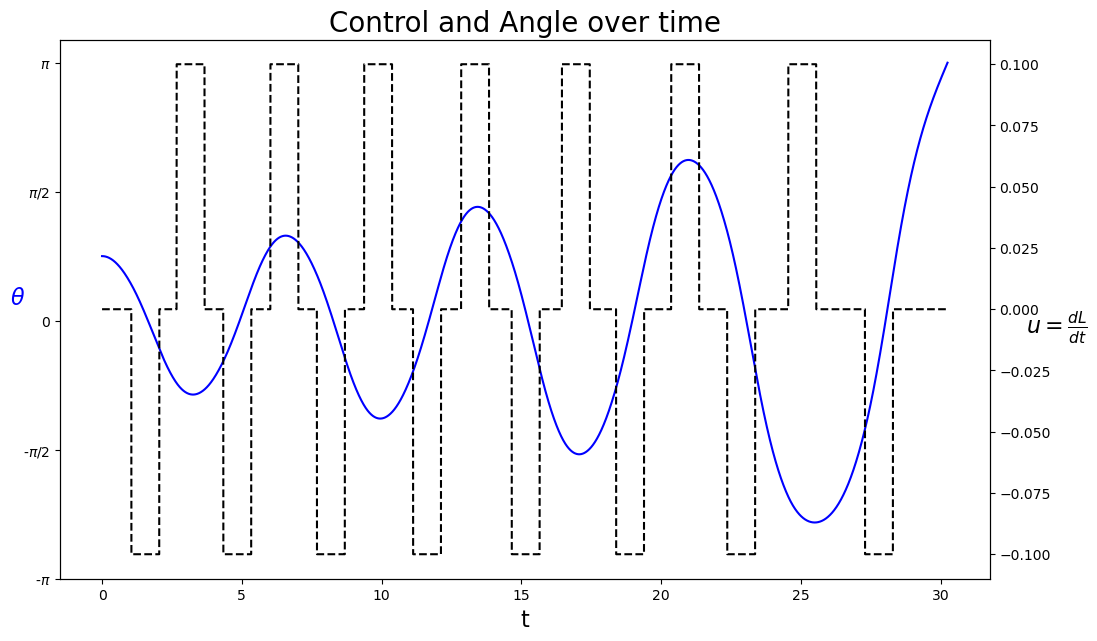

In [11]:
fig, ax1 = plt.subplots(figsize=(12, 7))

ax2 = ax1.twinx()
ax1.plot(t[:], phi[:] - np.pi, "b")
ax2.plot(l_dot_hist_t, l_dot_hist, "k--")

ax1.set_xlabel("t", fontsize=16)
ax1.set_ylabel(r"$\theta$", fontsize=16, color="b", rotation=0)
ax1.set_yticks([-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi])
ax1.set_yticklabels([r"-$\pi$", "-$\pi/2$", "0", "$\pi/2$", r"$\pi$"])
ax2.set_ylabel(r"$u = \frac{dL}{dt}$", color="k", fontsize=16, rotation=0)

plt.title("Control and Angle over time", fontsize=20)
# plt.show()
#plt.savefig("control_overlay.png")

In [12]:
control_dict = {"time": l_dot_hist_t, "control": l_dot_hist}
angle_dict = {"time": t, "angle": phi - np.pi}

In [13]:
control_angle_dict = {"time": l_dot_hist_t, "control": l_dot_hist, "angle": phi-np.pi}
control_angle_df = pd.DataFrame(control_angle_dict)

In [14]:
# ang_df = pd.DataFrame(angle_dict)
# ctrl_df = pd.DataFrame(control_dict)

In [15]:
env.pumps*env.tau

30.25

In [16]:
env.pumps

6050

In [17]:
env.phi[-1]

3.1395302537920715

In [18]:
(env.target - env.phi[-1])/env.target

0.0006564822448782365

In [ ]:
control_angle_df.tail()

In [19]:
control_angle_df.to_csv("unbounded_control_angle.csv")